In [1]:

import numpy as np 
import pandas as pd 
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from pascal_voc_writer import Writer
import tqdm
import imageai

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [0]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [0]:
! pip install pascal-voc-writer
# !pip install opencv-python==4.1.2.30
# !pip install keras==2.3.1
# !pip install tensorflow==1.14.0
# !pip install tensorflow-gpu==1.14.0
!pip install imageai --upgrade

     |████████████████████████████████| 184kB 2.7MB/s 


In [0]:
## decode run length encoding decoidng, maks image generation, pascal voc format annotations generation
def decodeRle(rleMask):
    rleMask = rleMask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (rleMask[0:][::2], rleMask[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(768*768, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(768,768).T

def generateMaskImage(masksList):
    maskImage = np.zeros(shape=(768,768))
    for mask in masksList:
        decodedMask = decodeRle(mask)
        maskImage+=decodedMask
    return maskImage
# def pre_process_images():
    
def getBoundingBox(maskImage):
    labels = label(maskImage) 
    coordinates = regionprops(labels)
    return coordinates

def generateTrainData():
    # trainImages = imageMasks.loc[imageMasks.EncodedPixels.isnull()==False]["ImageId"]
    # trainImages = np.unique(trainImages.values)
    for dirname, _, filenames in os.walk( trainImagesPath ):
        trainImages = filenames

    imagePath= modelFolder + "train/images/"
    annotationPath = modelFolder +"train/annotations/"
    for i,imageName in enumerate(trainImages):
        print(i)
        image = cv2.imread(trainImagesPath + imageName)
        masksList = imageMasks.loc[imageMasks["ImageId"]==imageName]["EncodedPixels"]
        maskImage = generateMaskImage(masksList)
        coordinates = getBoundingBox(maskImage)
        pascalVoc = Writer(imagePath + imageName, 768, 768)
        for coord in coordinates:
            # cv2.rectangle(image, (coord.bbox[1], coord.bbox[0]), (coord.bbox[3], coord.bbox[2]), (255, 0, 0), 2)
            pascalVoc.addObject('ship', coord.bbox[1], coord.bbox[0], coord.bbox[3], coord.bbox[2])
            
        # cv2.imwrite(os.path.join(imagePath , imageName), image)
        pascalVoc.save(annotationPath + imageName.split('.')[0] + ".xml")
        

def generateValidationData():
    for dirname, _, filenames in os.walk( valImagesPath):
      valImages = filenames
    # valImages = imageMasks.loc[imageMasks.EncodedPixels.isnull()==False]["ImageId"]
    # valImages = np.unique(valImages.values)
    imagePath=modelFolder + "validation/images/"
    annotationPath = modelFolder + "validation/annotations/"
    for i, imageName in enumerate(valImages):
        print(i)
        image = cv2.imread(valImagesPath + imageName)
        masksList = imageMasks.loc[imageMasks["ImageId"]==imageName]["EncodedPixels"]
        maskImage = generateMaskImage(masksList)
        coordinates = getBoundingBox(maskImage)
        pascalVoc = Writer(imagePath + imageName, 768, 768)
        for coord in coordinates:
            # cv2.rectangle(image, (coord.bbox[1], coord.bbox[0]), (coord.bbox[3], coord.bbox[2]), (255, 0, 0), 2)
            pascalVoc.addObject('ship', coord.bbox[1], coord.bbox[0], coord.bbox[3], coord.bbox[2])
            
        # cv2.imwrite(os.path.join(imagePath , imageName), image)
        pascalVoc.save(annotationPath + imageName.split('.')[0] + ".xml")


In [0]:
## generate pascal voc format annotations for trian images
generateTrainData()

In [0]:
## generate pascal voc format annotations for test images
generateValidationData()

In [0]:
#### run it once only, directory structure for YOLO
modelFolder = "/content/drive/My Drive/sml_project/model_755/"
os.mkdir(modelFolder +"train") 
os.mkdir(modelFolder +"validation")
os.mkdir(modelFolder +"train/images")
os.mkdir(modelFolder +"train/annotations")
os.mkdir(modelFolder +"validation/images")
os.mkdir(modelFolder +"validation/annotations")

In [0]:
## training cdv file read
trainCsvPath = '/content/drive/My Drive/sml_project/train_ship_segmentations_v2.csv'
trainImagesPath = modelFolder + 'train/images/'
valImagesPath = modelFolder + 'validation/images/'

imageMasks = pd.read_csv(os.path.join(trainCsvPath))
print(imageMasks.shape[0], 'masks found')
print(imageMasks['ImageId'].value_counts().shape[0])
imageMasks.head()


231723 masks found
192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [0]:
## data balancing, reducing size
trainCsv = pd.read_csv(trainCsvPath)
shipsCsv = trainCsv
shipCsv = shipsCsv.dropna()
shipsCount = shipCsv.groupby(['ImageId'], sort=True).size().reset_index(name='Count')
print("Total images having ships :", len(shipsCount))
print("\nNumber of Images having different number of ships\n")
# shipsCount["Count"].hist(bins=shipsCount['Count'].max())

datasetPath = "../airbus-ship-detection/train_v2/"
trainPath = "ships_dataset/train/"
testPath = "ships_dataset/test/"

 

Total images having ships : 42556

Number of Images having different number of ships

12333


In [0]:
## yolo training 
from imageai.Detection.Custom import DetectionModelTrainer

trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory="/content/model_755")
trainer.setTrainConfig(object_names_array=["ship"], batch_size=4, num_experiments=2, train_from_pretrained_model="/content/model_755/models/detection_model-ex-001--loss-0026.385.h5")
trainer.trainModel()


Generating anchor boxes for training images and annotation...
Average IOU for 9 anchors: 0.66
Anchor Boxes generated.
Detection configuration saved in  /content/model_755/json/detection_config.json
Training on: 	['ship']
Training with Batch Size:  4
Number of Experiments:  2
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.cast` instead.

Training with transfer learning from pretrained Model


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '







Epoch 1/2
1512/1512 [==============================] - 1533s 1s/step - loss: 14.4167 - yolo_layer_1_loss: 2.1929 - yolo_layer_2_loss: 3.7901 - yolo_layer_3_loss: 8.4337

Epoch 2/2
1512/1512 [==============================] - 1483s 981ms/step - loss: 12.5478 - yolo_layer_1_loss: 1.9203 - yolo_layer_2_loss: 3.2708 - yolo_layer_3_loss: 7.3566


In [0]:
## yolo evaluation , evaluation metric (no validation data , to  avoid memory error)
from imageai.Detection.Custom import DetectionModelTrainer

trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory="/content/model_755")
metrics = trainer.evaluateModel(model_path="/content/model_755/models/detection_model-ex-001--loss-0026.385.h5", json_path="/content/model_755/json/detection_config.json", iou_threshold=0.5, object_threshold=0.3, nms_threshold=0.5, )
print(metrics)

Starting Model evaluation....
Model File:  /content/model_755/models/detection_model-ex-001--loss-0026.385.h5 

Using IoU :  0.5
Using Object Threshold :  0.3
Using Non-Maximum Suppression :  0.5
ship: 0.0000
mAP: 0.0000
[{'model_file': '/content/model_755/models/detection_model-ex-001--loss-0026.385.h5', 'using_iou': 0.5, 'using_object_threshold': 0.3, 'using_non_maximum_suppression': 0.5, 'average_precision': {'ship': 0}, 'map': 0.0}]


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
## yolo box detection
from imageai.Detection.Custom import CustomObjectDetection

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath("/content/model_755/models/detection_model-ex-002--loss-0012.548.h5")
detector.setJsonPath("/content/model_755/json/detection_config.json")
detector.loadModel()
detections = detector.detectObjectsFromImage(input_image="/content/drive/My Drive/sml_project/test_v2/00a3ab3cc.jpg", output_image_path="2-detected.jpg", nms_treshold=0.2)
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

ship  :  70.60459852218628  :  [142, 417, 220, 481]


In [3]:

## yolo model 
from imageai.Detection.Custom import CustomObjectDetection
yoloModel = CustomObjectDetection()
yoloModel.setModelTypeAsYOLOv3()
yoloModel.setModelPath("yolo/models/detection_model-ex-001--loss-0026.385.h5")
yoloModel.setJsonPath("yolo/json/detection_config.json")
yoloModel.loadModel()


Using TensorFlow backend.


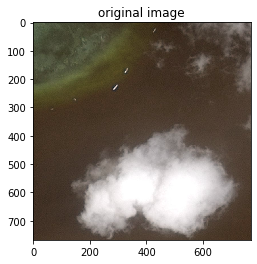

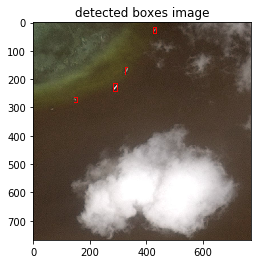

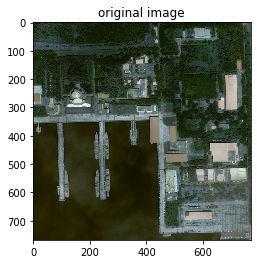

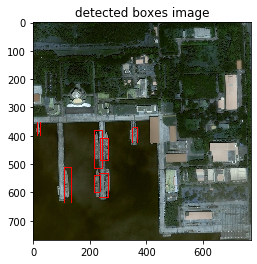

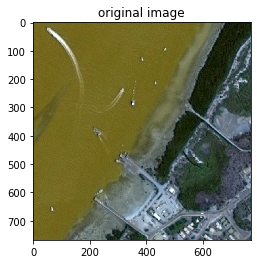

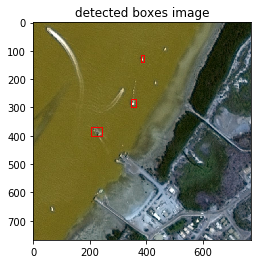

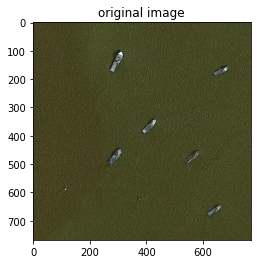

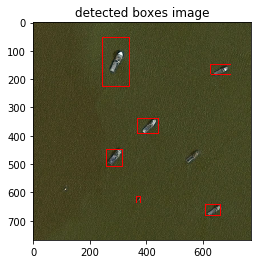

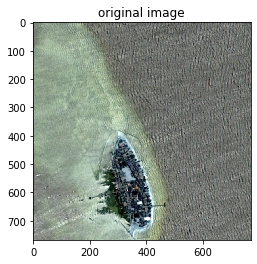

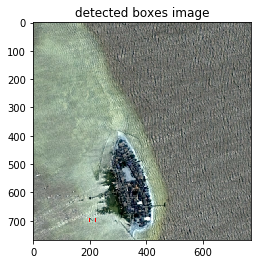

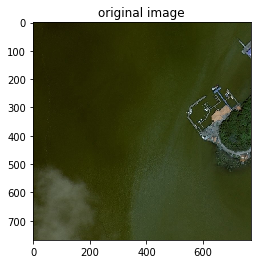

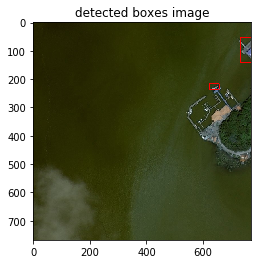

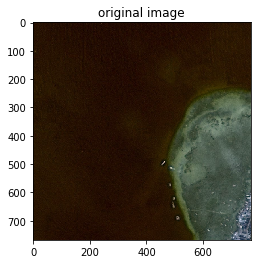

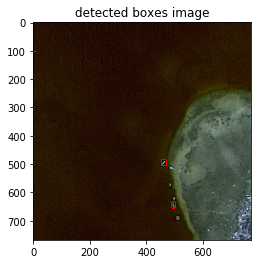

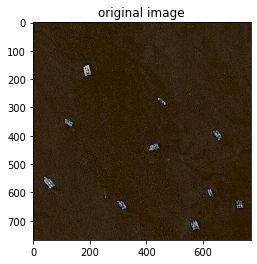

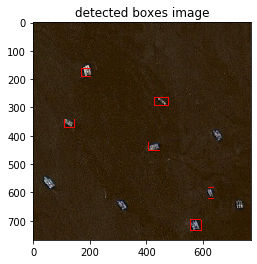

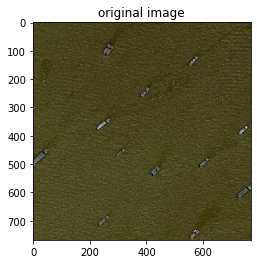

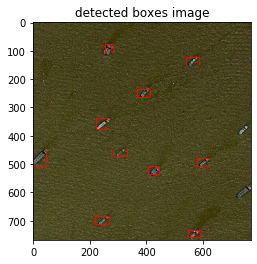

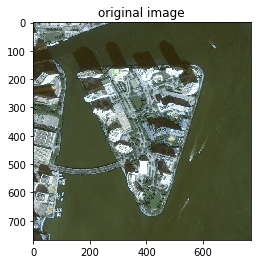

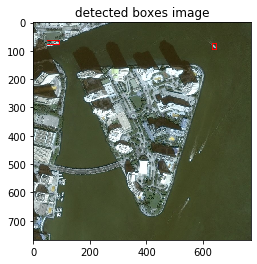

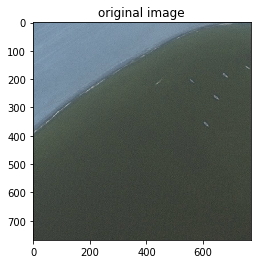

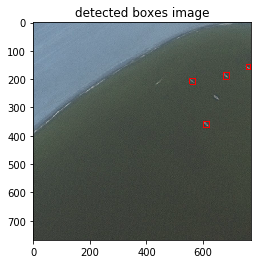

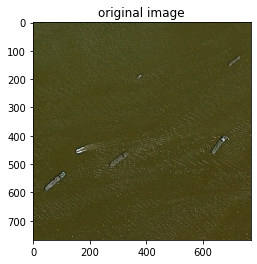

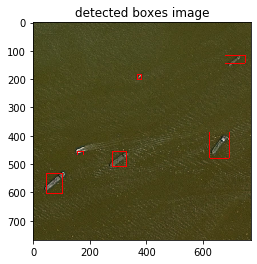

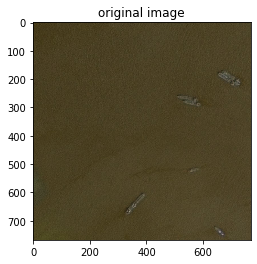

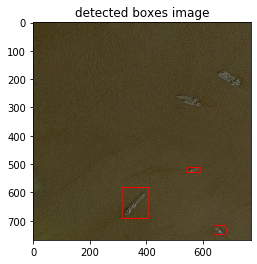

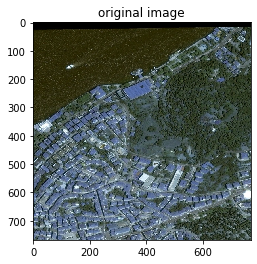

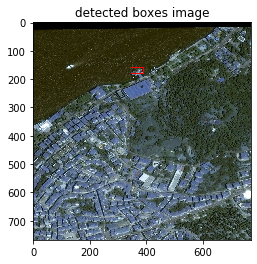

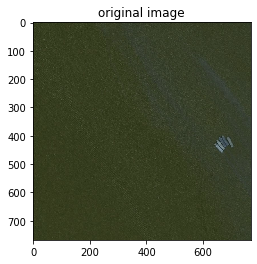

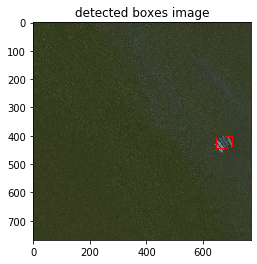

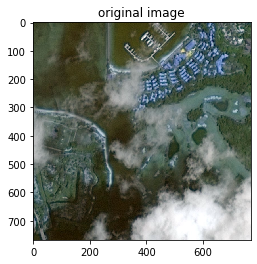

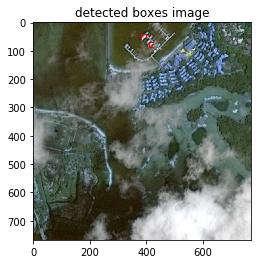

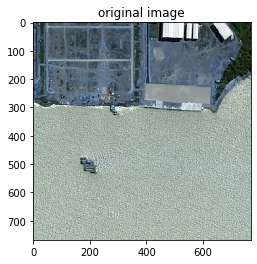

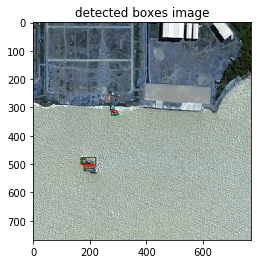

In [10]:
## testing on images

def yoloBBox(imagePath):
    bbox = yoloModel.detectObjectsFromImage(input_image=imagePath, output_image_path="random.jpg", nms_treshold=0.2)
    bboxList = []
    for box in bbox:
        bboxList.append(box["box_points"])
    return bboxList


imagesPath = "../code/ships_small_dataset/test/"

for dir,_, files in os.walk(imagesPath):
    for file in files[:20]:
        imagePath = imagesPath + file
        image = cv2.imread(imagePath)
        yoloBboxList = yoloBBox(imagePath)
        if(len(yoloBboxList) > 0):
            plt.figure()
            plt.imshow(image)
            plt.title("original image")
            for bbox in yoloBboxList:
                cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)
            plt.figure()
            plt.imshow(image)
            plt.title("detected boxes image")

In [9]:
import warnings
warnings.filterwarnings('ignore')